# Session 1: Normal Workflows

Let's activate our previously created environment and import BattMo into the kernel.

In [20]:
import Pkg
Pkg.activate("../") # Activates the environment in the current folder

using BattMo, GLMakie

  Activating project at `c:\Users\lorenah\Documents\Repositories\BattMo-workshop-2025-06-13`


### Part 1 - Handle Cell Parameters

To change cell parameters, we can modify the JSON files directly, or we can read them into objects in the script and modify them as Dictionaries. A loaded cell parameter set is a Dictionary-like object which come with additional handy functions. First, lets list the outermost keys of the cell parameters object.

In [21]:
cell_parameters = load_cell_parameters(; from_default_set = "Chen2020_calibrated")
keys(cell_parameters)

KeySet for a Dict{String, Any} with 6 entries. Keys:
  "Electrolyte"
  "Cell"
  "Metadata"
  "PositiveElectrode"
  "Separator"
  "NegativeElectrode"

Now we access the Separator key.

In [22]:
cell_parameters["Separator"]

Dict{String, Any} with 5 entries:
  "Description"          => "Ceramic-coated Polyolefin"
  "Density"              => 946
  "BruggemanCoefficient" => 1.5
  "Thickness"            => 1.2e-5
  "Porosity"             => 0.47

We have a flat list of parameters and values for the separator. In other cases, a key might nest other dictionaries, which can be accessed using the normal dictionary notation. Lets see for instance the active material parameters of the negative electrode.

In [23]:
cell_parameters["NegativeElectrode"]["ActiveMaterial"]

Dict{String, Any} with 16 entries:
  "ActivationEnergyOfDiffusion"       => 5000
  "NumberOfElectronsTransfered"       => 1
  "StoichiometricCoefficientAtSOC0"   => 0.0279
  "OpenCircuitPotential"              => "1.9793 * exp(-39.3631*(c/cmax)) + 0.2…
  "ReactionRateConstant"              => 6.716e-12
  "MassFraction"                      => 1.0
  "StoichiometricCoefficientAtSOC100" => 0.9014
  "ActivationEnergyOfReaction"        => 35000
  "MaximumConcentration"              => 33133.0
  "VolumetricSurfaceArea"             => 383959.0
  "Description"                       => "Graphite-SiOx"
  "DiffusionCoefficient"              => 3.3e-14
  "ParticleRadius"                    => 5.86e-6
  "Density"                           => 2260.0
  "ElectronicConductivity"            => 215
  "ChargeTransferCoefficient"         => 0.5

In addition to manipulating parameters as dictionaries, we provide additional handy attributes and functions. For instance, we can display all cell parameters:

In [24]:
cell_parameters

{
    "Electrolyte" =>     {
        "TransferenceNumber" => 0.2594
        "Description" => "1 mol/l LiPF6 with ethylene carbonate (EC): ethyl methyl carbonate (EMC) (3:7, V:V)"
        "DiffusionCoefficient" => "8.794*10^(-11)*(c/1000)^2 - 3.972*10^(-10)*(c/1000) + 4.862*10^(-10)"
        "IonicConductivity" => "0.1297*(c/1000)^3 - 2.51*(c/1000)^(1.5) + 3.329*(c/1000)"
        "Density" => 1200
        "ChargeNumber" => 1
        "Concentration" => 1000
    }
    "Cell" =>     {
        "NominalVoltage" => 3.71
        "ElectrodeGeometricSurfaceArea" => 0.1027
        "Height" => 0.065
        "NominalCapacity" => 4.8
        "Name" => "LG INR 21700 M50"
        "Case" => "Cylindrical"
        "OuterRadius" => 0.021
    }
    "Metadata" =>     {
        "Description" => "Parameter set of a cylindrical 21700 commercial cell (LGM50), for an electrochemical pseudo-two-dimensional (P2D) model, after calibration."
        "Source" => "https://doi.org/10.1149/1945-7111/ab9050"
        "Tit

However, there are many parameters, nested into dictionaries. Often, we are more interested in a specific subset of parameters. We can find a parameter with the search_parameter function. For example, we'd like to now how electrode related objects and parameters are named:

In [25]:
search_parameter(cell_parameters, "Concentration")

3-element Vector{Any}:
 "[NegativeElectrode][ActiveMaterial][MaximumConcentration] => 33133.0"
 "[PositiveElectrode][ActiveMaterial][MaximumConcentration] => 63104.0"
 "[Electrolyte][Concentration] => 1000"

The search function also accepts partial matches and it is case-insentive.

In [26]:
search_parameter(cell_parameters, "char")

3-element Vector{Any}:
 "[NegativeElectrode][ActiveMaterial][ChargeTransferCoefficient] => 0.5"
 "[PositiveElectrode][ActiveMaterial][ChargeTransferCoefficient] => 0.5"
 "[Electrolyte][ChargeNumber] => 1"

Parameter that take single numerical values (e.g. real, integers, booleans) can be directly modified. Examples:

In [27]:
cell_parameters["PositiveElectrode"]["ElectrodeCoating"]["Thickness"] = 8.2e-5

8.2e-5

Some parameters are described as functions or arrays, since the parameter value depends on other variables. For instance the Open Circuit Potentials of the Active Materials depend on the lithium stoichiometry and temperature.

......................Missing........................................................................

When we're unsure about the type or meaning of a parameter, we can print information on invidual parameters as well. For some parameters, that require more explanation, a link to the documentation is provided.

In [28]:
parameter_name = "OpenCircuitPotential"

print_parameter_info(parameter_name)

ℹ️  Parameter Information
Parameter                     type                                    unit
--------------------------------------------------------------------------------
OpenCircuitPotential          String, Dict{String, Vector}, Real      V



### Part 2 - Handle Cycling protocols

The cycling protocol parameters can be altered in the same way as the cell parameters. Let's load a default CCCV cycling protocol and change the number of cycles.

In [29]:
cycling_protocol = load_cycling_protocol(; from_file_path= "default_sets/cycling_protocols/CCCV.json")
cycling_protocol["TotalNumberOfCycles"] = 10

10

Let's run the CCCV protocol and plot some results

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lorenah\.julia\packages\ProgressMeter\kniaW\src\ProgressMeter.jl:607
Progress 100%|███████████████████████████████████████████| Time: 0:00:11

╭────────────────┬────────────┬────────────────┬──────────────╮
│ Iteration type │   Avg/step │   Avg/ministep │        Total │
│                │ 2811 steps │ 3004 ministeps │     (wasted) │
├────────────────┼────────────┼────────────────┼──────────────┤
│ Newton         │    2.81928 │        2.63815 │  7925 (1950) │
│ Linearization  │    3.88794 │        3.63815 │ 10929 (2080) │
│ Linear solver  │    2.81928 │        2.63815 │  7925 (1950) │
│ Precond apply  │        0.0 │            0.0 │        0 (0) │
╰────────────────┴────────────┴────────────────┴──────────────╯
╭───────────────┬────────┬────────────┬─────────╮
│ Timing type   │   Each │   Relative │   Total │
│               │     ms │ Percentage │       s │
├───────────────┼────────┼────────────┼─────────┤
│ Properties    │ 0.0444 │     3.09 % │  0.3518 │
│ Equations     │ 0.2411 │    23.17 % │  2.6349 │
│ Assembly      │ 0.1306 │    12.55 % │  1.4270 │
│ Linear solve  │ 0.4964 │    34.60 % │  3.9338 │
│ Linear setup  │ 0.0000

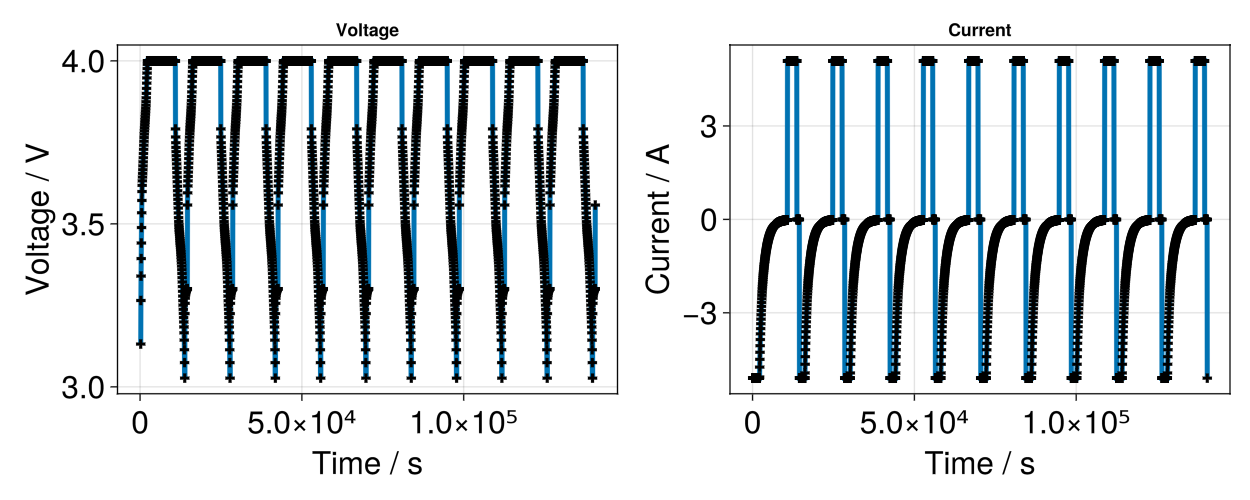

In [30]:
model_setup = LithiumIonBattery()

sim = Simulation(model_setup, cell_parameters, cycling_protocol)

output = solve(sim);

states = output[:states]

t = [state[:Control][:Controller].time for state in states]
E = [state[:Control][:Phi][1] for state in states]
I = [state[:Control][:Current][1] for state in states]

f = Figure(size = (1000, 400))

ax = Axis(f[1, 1],
	title = "Voltage",
	xlabel = "Time / s",
	ylabel = "Voltage / V",
	xlabelsize = 25,
	ylabelsize = 25,
	xticklabelsize = 25,
	yticklabelsize = 25,
)

scatterlines!(ax,
	t,
	E;
	linewidth = 4,
	markersize = 10,
	marker = :cross,
	markercolor = :black)

ax = Axis(f[1, 2],
	title = "Current",
	xlabel = "Time / s",
	ylabel = "Current / A",
	xlabelsize = 25,
	ylabelsize = 25,
	xticklabelsize = 25,
	yticklabelsize = 25)

scatterlines!(ax,
	t,
	I;
	linewidth = 4,
	markersize = 10,
	marker = :cross,
	markercolor = :black)

f

### Part 3 - Handle the simulation output

.........................................Missing..........................................................................